In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_digits

In [2]:
data = load_digits()
data.keys()

dict_keys(['DESCR', 'data', 'target', 'target_names', 'images'])

In [3]:
X = pd.DataFrame(data['data'])
X.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [4]:
y = pd.Series(data['target'])
y.head()

0    0
1    1
2    2
3    3
4    4
dtype: int64

In [5]:
y_dummy = pd.get_dummies(y)
y_dummy.head()

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

params = dict()

LinearRegression

In [9]:
#unavailable for multiclass
#params[LinearRegression()] = {
#    'n_jobs': [-1]
#}

LogisticRegression

In [10]:
lrp = {
    'C': [128./(2**x) for x in range(0, 20)],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['ovr'],
    'random_state': [0],
}
params[LogisticRegression()] = lrp
lrp_l1 = lrp.copy()
lrp_l1['penalty'] = ['l1']
lrp_l1['solver'] = ['liblinear', 'saga']
params[LogisticRegression()] = lrp_l1

KNeighborsClassifier

In [11]:
params[KNeighborsClassifier()] = {
    'n_neighbors': [1, 5, 10, 20, 40, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, np.inf],
}

DecisionTreeClassifier

In [12]:
params[DecisionTreeClassifier()] = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 3, 5, 8, 13, 21],
    'max_leaf_nodes': [2, 3, 5, 8, 13, 21],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [0]
}

LinearSVC

In [13]:
params[LinearSVC()] = {
    'C': [128./(2**x) for x in range(0, 20)],
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge'],
    'multi_class': ['ovr', 'crammer_singer'],
    'random_state': [0],
}

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve

In [20]:
y_train_dummy = pd.get_dummies(y_train)
y_test_dummy = pd.get_dummies(y_test)

roc_curves = dict()
pr_curves = dict()
for model, p in params.items():
    gs = GridSearchCV(estimator=model, param_grid=p, scoring='accuracy', cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)
    
    model_class = model.__class__
    
    message = "Model {} achieve {} score with params:\n{}".\
        format(model_class.__name__, gs.best_score_, gs.best_params_)
    print(message)
    
    # we need only best scores of the model
    if (model_class in roc_curves) and curves[model_class][2] > gs.best_score_:
        continue

    classifier = OneVsRestClassifier(gs.best_estimator_)
    classifier.fit(X_train, y_train_dummy)
    
    try:
        y_score = classifier.decision_function(X_test)
    except:
        y_score = classifier.predict_proba(X_test)
    
    yy_test, yy_pred = np.array(y_test_dummy).ravel(), y_score.ravel()
    # roc curve
    fpr, tpr, _ = roc_curve(yy_test, yy_pred)
    roc_curves[model_class] = (fpr, tpr, gs.best_score_)
    # precision recall curve
    pr, re, _ = precision_recall_curve(yy_test, yy_pred)
    pr_curves[model_class] = (pr, re, gs.best_score_)

Model LogisticRegression achieve 0.9679888656924147 score with params:
{'C': 0.25, 'solver': 'sag', 'multi_class': 'ovr', 'random_state': 0, 'penalty': 'l2'}
Model KNeighborsClassifier achieve 0.9874739039665971 score with params:
{'weights': 'distance', 'p': 1, 'n_neighbors': 5}
Model LogisticRegression achieve 0.9679888656924147 score with params:
{'C': 16.0, 'solver': 'saga', 'multi_class': 'ovr', 'random_state': 0, 'penalty': 'l1'}
Model LinearSVC achieve 0.9728601252609603 score with params:
{'C': 0.001953125, 'multi_class': 'crammer_singer', 'random_state': 0, 'penalty': 'l2', 'loss': 'hinge'}
Model DecisionTreeClassifier achieve 0.7919276270006959 score with params:
{'random_state': 0, 'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 21, 'max_features': None}


ROC curves

Populating the interactive namespace from numpy and matplotlib


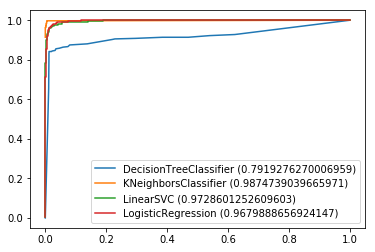

In [25]:
import pylab as pl
%pylab inline

for model_class, (fpr, tpr, score) in roc_curves.items():
    pl.plot(fpr, tpr, label="{} ({})".format(model_class.__name__, score))
pl.legend();

Precision Recall curves

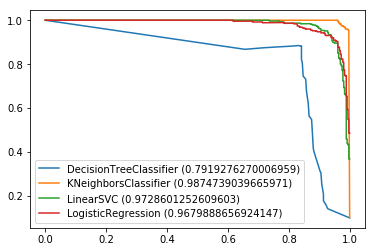

In [26]:
for model_class, (pr, re, score) in pr_curves.items():
    pl.plot(re, pr, label="{} ({})".format(model_class.__name__, score))
pl.legend();